In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm_notebook
from sklearn import preprocessing

In [2]:
station_data = pd.read_csv('station_data.csv')
trip_data = pd.read_csv('trip_data.csv')
weather_data = pd.read_csv('weather_data.csv')

station_data['Id'] = station_data['Id'].astype(str)

trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'])
trip_data['End Date'] = pd.to_datetime(trip_data['End Date'])
trip_data['Start Station'] = trip_data['Start Station'].astype(str)
trip_data['End Station'] = trip_data['End Station'].astype(str)

weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data['Date'] = weather_data['Date'].apply(lambda x : x.date())
weather_data['Events'] = weather_data['Events'].fillna('None')

def zip_to_city(zip_code):
    switcher = {
        94107: 'San Francisco',
        94063: 'Redwood City',
        94301: 'Palo Alto',
        94041: 'Mountain View',
        95113: 'San Jose'
    }
    return switcher.get(zip_code)
weather_data['City'] = list((map(zip_to_city, weather_data['Zip'])))
weather_data = weather_data.drop(['Zip'], axis=1)

# Notes

Stations 23,25,49,69, 72 -> 85,86,87,88,89 -> 90

Net rate = trips ended - trips started (for a given hour)

In [3]:
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [4]:
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer


In [5]:
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,City
0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,None,290.0,San Francisco
1,2014-02-09,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,None,290.0,San Francisco
2,2014-03-09,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,None,276.0,San Francisco
3,2014-04-09,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,None,301.0,San Francisco
4,2014-05-09,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,None,309.0,San Francisco


In [6]:
weather_data['Events'].unique()

array(['None', 'Rain', 'Fog', 'Fog-Rain', 'Rain-Thunderstorm'],
      dtype=object)

# Step 1: Problem analysis

What do we want to achieve?

What models/algorithms are likely to be applicable?

Initial feeling of avenues to pursue?

## Objectives

Predict the net rate per given hour - assume "clock hr of the day" (24 hr-windows)

Therefore, a regression problem -> predict a continuous value

## Data

Station info, trip data, daily weather

Station ID is important factor. Most of rest of trip data fields will merely serve to generate labelled data.

Station info can influence rate by geolocation, affluency/culture, dock count

Daily weather measurements can have influence on whether people are eager to cycle

## Potential models

### Accuracy

Random Forest, Neural Network, Gradient Boosting Tree

### Speed

Decision Tree, Linear Regression


# Step 2: Make some labelled data

Actual net rate per hour

Assume "per clock hour of each day"

In [7]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Trip ID          354152 non-null  int64         
 1   Start Date       354152 non-null  datetime64[ns]
 2   Start Station    354152 non-null  object        
 3   End Date         354152 non-null  datetime64[ns]
 4   End Station      354152 non-null  object        
 5   Subscriber Type  354152 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 16.2+ MB


In [8]:
end_indexed = trip_data.set_index('End Date')
#display(end_indexed)
grouper = end_indexed.groupby([pd.Grouper(freq='1H'), 'End Station'])
end_result = grouper['Trip ID'].count().unstack('End Station').fillna(0)
#display(end_result)
#end_result.plot(figsize=(20,10))

In [9]:
start_indexed = trip_data.set_index('Start Date')
#display(end_indexed)
grouper = start_indexed.groupby([pd.Grouper(freq='1H'), 'Start Station'])
start_result = grouper['Trip ID'].count().unstack('Start Station').fillna(0)
#display(start_result)
#start_result.plot(figsize=(20,10))

Station ID,10,11,12,13,14,16,2,21,22,23,...,82,83,84,85,86,87,88,89,9,90
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-09 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-08 19:00:00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,-5.0,0.0,1.0,0.0
2015-12-08 20:00:00,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,-1.0,5.0,0.0,1.0,0.0
2015-12-08 21:00:00,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


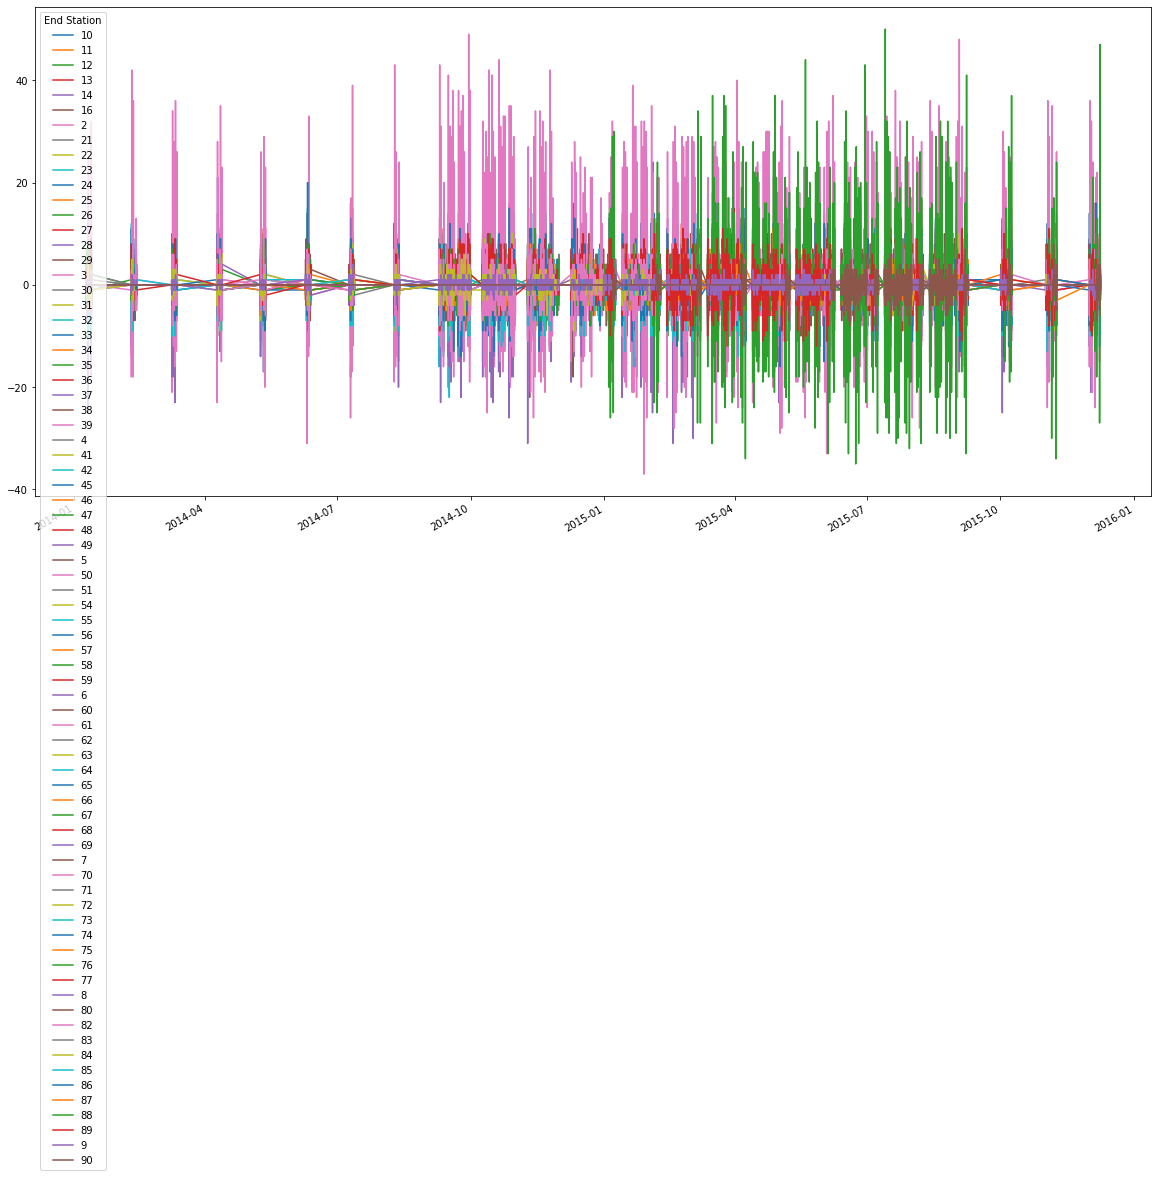

In [10]:
net_rates_by_station = end_result - start_result
net_rates_by_station.fillna(0, inplace=True)
net_rates_by_station.plot(figsize=(20,10))
net_rates_by_station.index.name = 'Datetime'
net_rates_by_station.columns.name = 'Station ID'
display(net_rates_by_station)

In [11]:
def check_station_id(station_ID):
    return station_ID in station_data['Id'].unique()

def get_net_rate(datetime, station_ID):
    if check_station_id(station_ID):
        return [net_rates_by_station.loc[datetime][station_ID]]
    else: print('Station ID doesn\'t exist: %d' % station_ID)

def get_weather(datetime, station_ID):
    if check_station_id(station_ID):
        station_city = station_data[station_data['Id'] == station_ID].iloc[0]['City']
        df = weather_data[(weather_data['Date'] == datetime.date()) & (weather_data['City'] == station_city)].drop(['Date'], axis=1)
        return df.values.tolist()[0]
    else: print('Station ID doesn\'t exist: %d' % station_ID)
        
def get_station(station_ID):
    if check_station_id(station_ID):
        df = station_data[station_data['Id'] == station_ID].drop(['Name','City'], axis=1)
        return df.values.tolist()[0]
    else: print('Station ID doesn\'t exist: %d' % station_ID)
        
# https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning
# https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
def get_cyclic_datetime(datetime):
    days_in_month = datetime.days_in_month
    days_in_year = 366 if datetime.is_leap_year else 365
    
    year = str(datetime.year)
    month_sin = np.sin(2*np.pi*datetime.month/12)
    month_cos = np.cos(2*np.pi*datetime.month/12)
    day_sin = np.sin(2*np.pi*datetime.day/days_in_month)
    day_cos = np.cos(2*np.pi*datetime.day/days_in_month)
    day_of_week_sin = np.sin(2*np.pi*datetime.dayofweek/7)
    day_of_week_cos = np.cos(2*np.pi*datetime.dayofweek/7)
    day_of_year_sin = np.sin(2*np.pi*datetime.dayofyear/days_in_year)
    day_of_year_cos = np.cos(2*np.pi*datetime.dayofyear/days_in_year)
    hour_sin = np.sin(2*np.pi*datetime.hour/24)
    hour_cos = np.cos(2*np.pi*datetime.hour/24)
    minute_sin = np.sin(2*np.pi*datetime.minute/60)
    minute_cos = np.cos(2*np.pi*datetime.minute/60)
    return [
        year, 
        month_sin, 
        month_cos, 
        day_sin, 
        day_cos, 
        day_of_week_sin,
        day_of_week_cos,
        day_of_year_sin, 
        day_of_year_cos,
        hour_sin,
        hour_cos,
        minute_sin,
        minute_cos
    ]

def get_dataset_columns():
    station_cols = list(station_data.drop(['Name','City'], axis=1).columns.values)
    net_rate_cols = ['Net Rate']
    time_cols = [
        'Year', 
        'Month (sine)',
        'Month (cosine)',
        'Day (sine)',
        'Day (cosine)',
        'Day of Week (sine)',
        'Day of Week (cosine)',
        'Day of Year (sine)',
        'Day of Year (cosine)',
        'Hour (sine)',
        'Hour (cosine)',
        'Minute (sine)',
        'Minute (cosine)',
    ]
    weather_cols = list(weather_data.drop(['Date'], axis=1).columns.values)
    return station_cols + net_rate_cols + time_cols + weather_cols

def gen_dataset_row(datetime, station_ID):
    station = get_station(station_ID)
    net_rate = get_net_rate(datetime, station_ID)
    time = get_cyclic_datetime(datetime)
    weather = get_weather(datetime, station_ID)
    
    return station + net_rate + time + weather

def gen_dataset():
    time_range = net_rates_by_station.index.tolist()
    station_IDs = station_data['Id'].unique()
    rows = []
    for station_ID in tqdm_notebook(station_IDs, desc='Station IDs'):
        for datetime in tqdm_notebook(time_range, desc='Hour intervals'):
            rows.append(gen_dataset_row(datetime, station_ID))
    return pd.DataFrame(rows, columns=get_dataset_columns())
        
    
#test_date = pd.to_datetime('2015-12-08 22:00:00')
#test_station = '2'
#display(gen_dataset_row(test_date, test_station))

In [12]:
#dataset = gen_dataset()
#display(dataset)

In [13]:
#dataset.to_csv('./input_dataset.csv')

In [14]:
dataset = pd.read_csv('input_dataset.csv')

In [15]:
x = dataset.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_scaled = pd.DataFrame(x_scaled)

f = plt.figure(figsize=(19, 15))
plt.matshow(dataset_scaled.corr(), fignum=f.number)
plt.xticks(range(dataset_scaled.shape[1]), dataset_scaled.columns, fontsize=14, rotation=45)
plt.yticks(range(dataset_scaled.shape[1]), dataset_scaled.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

ValueError: could not convert string to float: 'None'

In [ ]:
#
# DEPRECATED
#

# THIS DOESN'T COUNT PER STATION THOUGH

dates = [min(trip_data['Start Date']), max(trip_data['Start Date']), min(trip_data['End Date']), max(trip_data['End Date'])]
print(min(dates))
print(max(dates))

# Create range of hour intervals
rng = pd.date_range(start=min(dates), end=max(dates), freq='H', normalize=True)

# Nr of trips ended in hour interval

new_index = trip_data.set_index('End Date', drop=False).index
end_counts = pd.DataFrame(0, index=new_index, columns=['Trips Ended'])
end_counts = end_counts.resample('H').count()
#display(end_counts)
print('Total trips ended checks out? ', end_counts['Trips Ended'].sum() == len(trip_data))

# Nr of trips started in hour interval
new_index = trip_data.set_index('Start Date', drop=False).index
start_counts = pd.DataFrame(0, index=new_index, columns=['Trips Started'])
start_counts = start_counts.resample('H').count()
#display(start_counts)
print('Total trips started checks out? ', start_counts['Trips Started'].sum() == len(trip_data))

# Net rate = ended - started
trip_counts_df = end_counts.merge(start_counts, left_index=True, right_index=True)
trip_counts_df.index.name = 'Hour'
trip_counts_df['Net Rate'] = trip_counts_df['Trips Ended'] - trip_counts_df['Trips Started']
display(trip_counts_df)

trip_counts_df['Net Rate'].plot(figsize=(20,10))

# Step 3: Data exploration

Some plots comparing possibly useful features

Enough data points for neural net?

# Step 4: Data input to models

Extract and combine features

Normalise

# Step 4: Models

# Step 5: Performance